In [1]:
# SHAP Interpretation


In [3]:
import warnings, numpy as np, pandas as pd, shap, joblib
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
shap.initjs()

DATA_PATH = Path("../data/stroke_clean.csv")
ART_DIR  = Path("../artifacts"); ART_DIR.mkdir(exist_ok=True)


In [5]:
df = pd.read_csv(DATA_PATH)
df["stroke"] = df["stroke"].astype(int)

# Same feature selection I used Modeling Stage, i.e 02_Modeling...file
selected_feats = ["age","hypertension","heart_disease","avg_glucose_level","bmi","smoking_status"]
target = "stroke"
df = df[selected_feats + [target]].copy()

# simple interactions (as in modeling
df["age_bmi_interaction"] = df["age"] * df["bmi"]
df["age_glucose_ratio"]   = df["avg_glucose_level"] / (df["age"] + 1)

# normalize smoking text & flag unknown
df["smoking_status"] = df["smoking_status"].astype(str).str.lower().fillna("unknown")
df["smoking_known"]  = (df["smoking_status"] != "unknown").astype(int)

num_features = ["age","avg_glucose_level","bmi","age_bmi_interaction","age_glucose_ratio"]
cat_features = ["smoking_status","smoking_known"]

X = df[num_features + cat_features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_split = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)


In [7]:
# // Recreate Preprocessing
pre_num = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler",  Standardized := StandardScaler())])
pre_cat = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                    ("ohe",     OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer([
    ("num", pre_num, num_features),
    ("cat", pre_cat, cat_features)
])

def feature_names_after_preprocess(preprocess, X_sample):
    preprocess.fit(X_sample)  # fit on training split
    num_names = np.array(num_features)
    cat_names = preprocess.named_transformers_["cat"]["ohe"].get_feature_names_out(cat_features)
    return np.concatenate([num_names, cat_names])


In [8]:
logit_path = ART_DIR/"logit_balanced.pkl"
xgb_path   = ART_DIR/"xgb_tuned.pkl"   # from 02 if you saved it

try:
    logit = joblib.load(logit_path)
    print("Loaded saved Logistic pipeline.")
except:
    logit = Pipeline([
        ("pre", preprocess),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear")),
    ])
    logit.fit(X_train, y_train)
    joblib.dump(logit, logit_path)
    print("Trained & saved lightweight Logistic (balanced).")

try:
    xgb_tuned = joblib.load(xgb_path)
    print("Loaded saved XGB pipeline.")
except:
    # light XGB (no CV) for SHAP illustration if you didn't save tuned one
    neg, pos = int((y_train==0).sum()), int((y_train==1).sum())
    spw = neg/max(pos,1)
    xgb_tuned = Pipeline([
        ("pre", preprocess),
        ("clf", XGBClassifier(
            n_estimators=400, max_depth=4, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9, gamma=0.3,
            reg_lambda=1.0, random_state=42, n_jobs=-1,
            eval_metric="logloss", scale_pos_weight=spw
        ))
    ])
    xgb_tuned.fit(X_train, y_train)
    joblib.dump(xgb_tuned, xgb_path)
    print("Trained & saved lightweight XGB for SHAP.")


Trained & saved lightweight Logistic (balanced).
Trained & saved lightweight XGB for SHAP.


In [12]:
# use the fitted preprocess from the pipelines:
pre_fitted = logit.named_steps["pre"]  # both pipelines share the same structure

Xtr_enc = pre_fitted.transform(X_train)
Xte_enc = pre_fitted.transform(X_test)

# ensure dense for SHAP if sparse
if hasattr(Xtr_enc, "toarray"):
    Xtr_enc = Xtr_enc.toarray()
    Xte_enc = Xte_enc.toarray()

feat_names = feature_names_after_preprocess(preprocess, X_train)
len(feat_names), Xtr_enc.shape, Xte_enc.shape


(11, (4088, 11), (1022, 11))

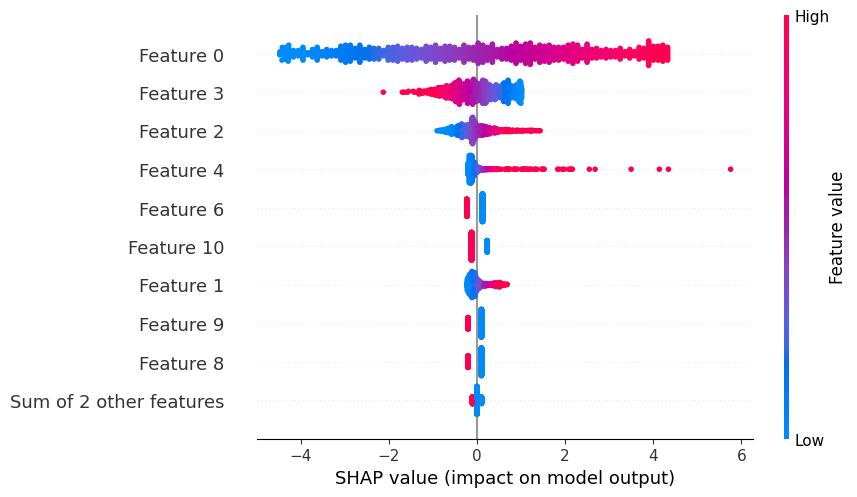

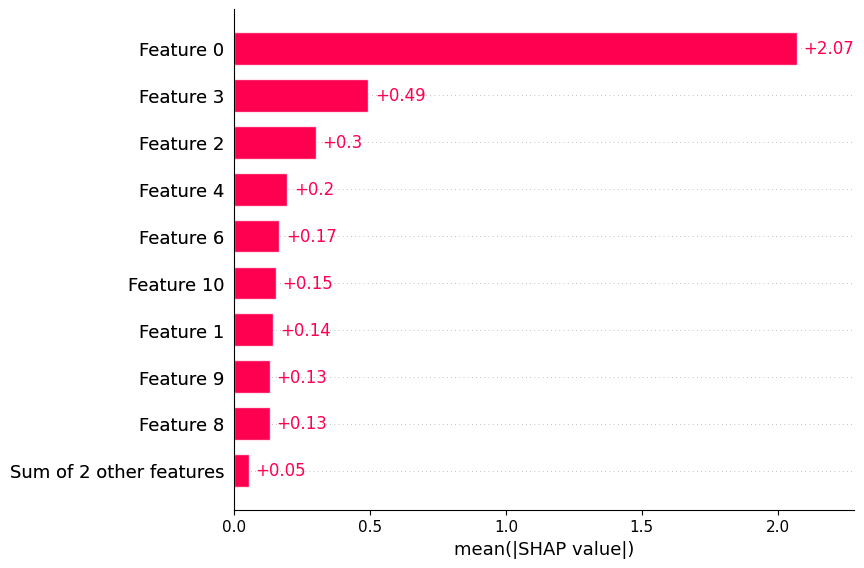

Logit high-risk prob: 0.9468736279558263 low-risk prob: 0.0064130292185126244


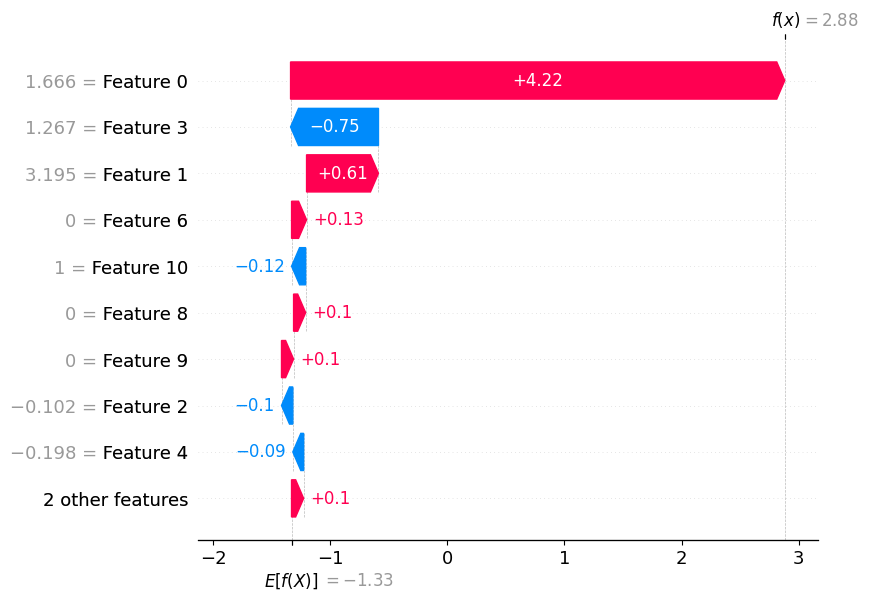

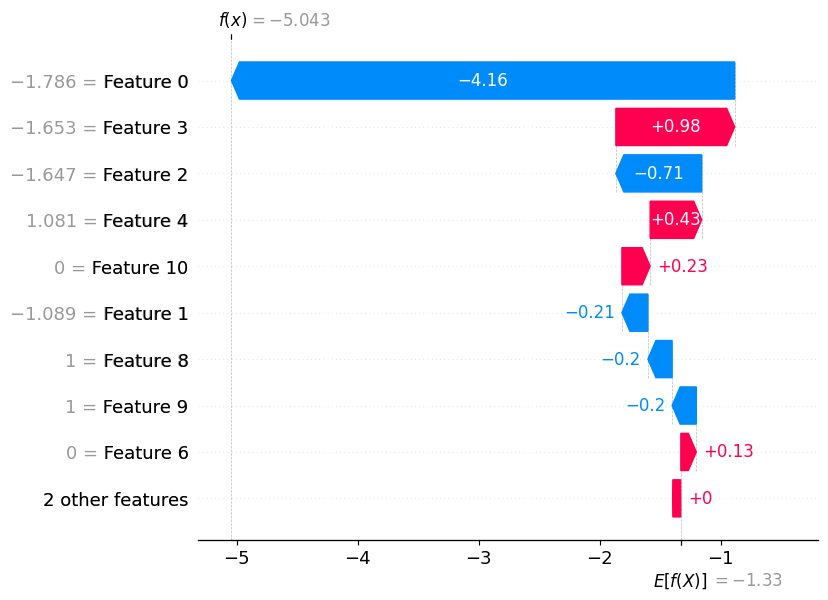

In [30]:
# For Logistic Regression

import numpy as np, shap

# --- use encoded train/test from your pipeline ---
# Xtr_enc, Xte_enc = pre_fitted.transform(X_train), pre_fitted.transform(X_test)
if hasattr(Xtr_enc, "toarray"):  # OneHot often yields sparse matrices
    Xtr_enc = Xtr_enc.toarray()
    Xte_enc = Xte_enc.toarray()

# small background for masker
bg_idx = np.random.default_rng(42).choice(Xtr_enc.shape[0], size=min(1000, Xtr_enc.shape[0]), replace=False)
background = Xtr_enc[bg_idx]

# build a masker (replaces feature_dependence="independent")
masker = shap.maskers.Independent(background)

# use the *fitted* LR estimator from your pipeline
logit_est = logit.named_steps["clf"]

# modern API: Explainer picks LinearExplainer under-the-hood for LR
lin_exp = shap.Explainer(logit_est, masker)
sv_logit = lin_exp(Xte_enc)  # returns shap.Explanation

# Global: beeswarm + bar
shap.plots.beeswarm(sv_logit, show=True)          # replaces summary_plot(..., plot_type="dot")
shap.plots.bar(sv_logit, show=True)               # mean|SHAP| bar plot

# Local: pick high-risk and low-risk examples
probs_logit = logit.predict_proba(X_test)[:, 1]
hi_idx = int(np.argmax(probs_logit))
lo_idx = int(np.argmin(probs_logit))

print("Logit high-risk prob:", probs_logit[hi_idx], "low-risk prob:", probs_logit[lo_idx])

shap.plots.waterfall(sv_logit[hi_idx], show=True)
shap.plots.waterfall(sv_logit[lo_idx], show=True)

In [32]:
# --- SHAP for XGBoost: version-robust, no generic masker needed ---
import numpy as np, shap

# 1) Grab fitted pieces from your tuned pipeline
pre = xgb_tuned.named_steps["pre"]    # ColumnTransformer (already fit)
xgb_est = xgb_tuned.named_steps["clf"]  # fitted XGBClassifier

# 2) Encode train/test exactly as the model sees them
Xtr_enc = pre.transform(X_train)
Xte_enc = pre.transform(X_test)

# Densify if OneHotEncoder gave sparse matrix
if hasattr(Xtr_enc, "toarray"):
    Xtr_enc = Xtr_enc.toarray()
    Xte_enc = Xte_enc.toarray()

# Try to get feature names from the ColumnTransformer (sklearn >=1.0)
try:
    feat_names = pre.get_feature_names_out().tolist()
except Exception:
    # Fallback: make generic names
    feat_names = [f"f{i}" for i in range(Xtr_enc.shape[1])]

# 3) Build TreeExplainer directly (no generic Explainer + masker)
#    Use interventional perturbation and probability output for nicer interpretability.
try:
    explainer = shap.TreeExplainer(
        xgb_est,
        feature_perturbation="interventional",
        model_output="probability",
    )
except TypeError:
    # Some SHAP versions use `feature_perturbation` implicitly; fall back safely
    explainer = shap.TreeExplainer(xgb_est)

# 4) Compute SHAP values on test encodings (handle both new/old APIs)
try:
    # New API returns shap.Explanation
    exp = explainer(Xte_enc)
    # Global importance
    shap.plots.beeswarm(exp, show=True)
    shap.plots.bar(exp, show=True)

    # Local explanations on a high-risk and low-risk test case
    probs_xgb = xgb_tuned.predict_proba(X_test)[:, 1]
    hi_idx = int(np.argmax(probs_xgb))
    lo_idx = int(np.argmin(probs_xgb))
    print("XGB high-risk prob:", probs_xgb[hi_idx], "low-risk prob:", probs_xgb[lo_idx])

    # Attach feature names for nicer plots if missing
    if exp.feature_names is None and feat_names:
        exp.feature_names = feat_names
    shap.plots.waterfall(exp[hi_idx], show=True)
    shap.plots.waterfall(exp[lo_idx], show=True)

except TypeError:
    # Old API: .shap_values returns numpy arrays
    sv = explainer.shap_values(Xte_enc)            # (n_samples, n_features)
    base = explainer.expected_value

    # Global summary plots (legacy)
    shap.summary_plot(sv, Xte_enc, feature_names=feat_names, show=True)
    shap.summary_plot(sv, Xte_enc, feature_names=feat_names, plot_type="bar", show=True)

    # Local waterfalls (legacy helper)
    probs_xgb = xgb_tuned.predict_proba(X_test)[:, 1]
    hi_idx = int(np.argmax(probs_xgb))
    lo_idx = int(np.argmin(probs_xgb))

    shap.plots._waterfall.waterfall_legacy(
        shap.Explanation(values=sv[hi_idx], base_values=base, data=Xte_enc[hi_idx], feature_names=feat_names)
    )
    shap.plots._waterfall.waterfall_legacy(
        shap.Explanation(values=sv[lo_idx], base_values=base, data=Xte_enc[lo_idx], feature_names=feat_names)
    )


ValueError: could not convert string to float: '[5E-1]'